# Breast Ultrasound Image Classification using PyTorch

This notebook implements an end-to-end deep learning project for breast ultrasound image classification. The model will classify images as Normal, Benign, or Malignant, which has significant clinical applications for breast cancer detection.


## 1. Setup and Imports

# Install required packages
!pip install torch torchvision tqdm matplotlib scikit-learn pillow pandas numpy gradio kaggle

In [1]:
# Basic imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import zipfile
import shutil

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# For deployment
import gradio as gr


In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Defining Datasets

In [3]:
# Define constants
DATA_DIR = r"C:\Users\ksska\OneDrive\Desktop\Project"  # Dataset directory
OUTPUT_DIR = r"C:\Users\ksska\OneDrive\Desktop\Project\results"  # Results directory
CLASSES = ["normal", "benign", "malignant"]  # Class names
NUM_CLASSES = len(CLASSES)

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

Dataset Check

In [4]:
def check_dataset():
    """
    Check if the dataset is already downloaded and in the correct structure
    """
    if not os.path.exists(DATA_DIR):
        print(f"Data directory {DATA_DIR} not found.")
        return False
    
    for class_name in CLASSES:
        class_dir = os.path.join(DATA_DIR, class_name)
        if not os.path.exists(class_dir):
            print(f"Class directory {class_dir} not found.")
            return False
    
    print("Dataset found!")
    return True

# Try to download if dataset not found
if not check_dataset():
    try:
        download_from_kaggle()
    except Exception as e:
        print(f"Dataset download failed: {e}")
        print("Please download the dataset manually from Kaggle:")
        print("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset")
        print(f"Extract it to {DATA_DIR} directory.")

# Print dataset summary
total_images = 0
print("\nDataset summary:")
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_dir):
        # Count only image files (not mask files)
        num_images = len([f for f in os.listdir(class_dir) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png')) 
                         and not f.lower().endswith(('_mask.png', '_mask.jpg'))])
        print(f"  {class_name.capitalize()}: {num_images} images")
        total_images += num_images

print(f"Total images: {total_images}")

Dataset found!

Dataset summary:
  Normal: 133 images
  Benign: 448 images
  Malignant: 211 images
Total images: 792


Dataset Visualization

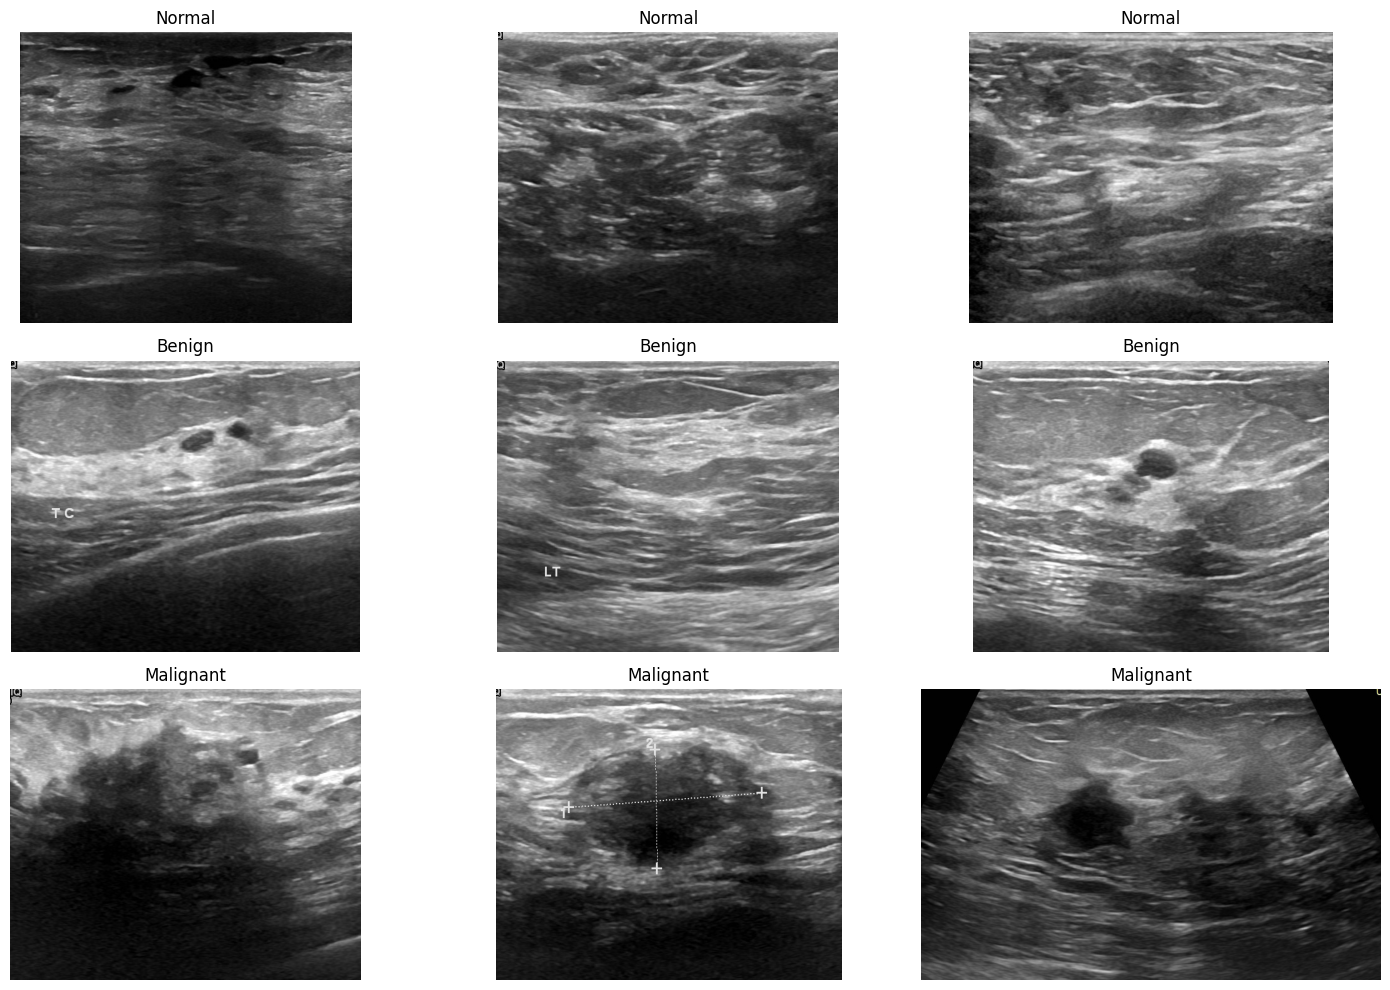

In [5]:
def visualize_samples(n_samples=3):
    """Visualize sample images from each class"""
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(CLASSES):
        class_dir = os.path.join(DATA_DIR, class_name)
        if not os.path.exists(class_dir):
            continue
            
        # Get only the actual images (not the masks)
        files = [f for f in os.listdir(class_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) 
                and not f.lower().endswith(('_mask.png', '_mask.jpg'))]
        
        if not files:
            continue
            
        # Select random samples
        samples = random.sample(files, min(n_samples, len(files)))
        
        for j, file in enumerate(samples):
            img_path = os.path.join(class_dir, file)
            img = Image.open(img_path)
            
            plt.subplot(len(CLASSES), n_samples, i*n_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{class_name.capitalize()}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_samples(n_samples=3)

## 4. Data Loading and Preparation

In [6]:
# Define the custom dataset class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def prepare_data(data_dir, test_size=0.2, val_size=0.1):
    """
    Prepare train/val/test splits from the dataset
    """
    all_images = []
    all_labels = []
    
    # Collect all images and their labels
    for class_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Class directory {class_dir} not found.")
            continue
            
        # Get only the actual images (not the masks)
        for img_name in os.listdir(class_dir):
            if (img_name.lower().endswith(('.jpg', '.jpeg', '.png')) 
                and not img_name.lower().endswith(('_mask.png', '_mask.jpg'))):
                img_path = os.path.join(class_dir, img_name)
                all_images.append(img_path)
                all_labels.append(class_idx)
    
    # Split into train+val and test
    train_val_images, test_images, train_val_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=test_size, stratify=all_labels, random_state=42
    )
    
    # Split train+val into train and val
    val_ratio = val_size / (1 - test_size)
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_val_images, train_val_labels, test_size=val_ratio, stratify=train_val_labels, random_state=42
    )
    
    print(f"Train images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")
    print(f"Test images: {len(test_images)}")
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)


In [7]:
# Define data transformations with augmentation for training
def get_transforms():
    # Transforms for training with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        v2.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        v2.RandomHorizontalFlip(),
        v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        v2.RandomAdjustSharpness(sharpness_factor=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transforms for validation and testing (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [8]:
# Prepare the datasets
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = prepare_data(DATA_DIR)

# Get transformations
train_transform, val_transform = get_transforms()

Train images: 553
Validation images: 80
Test images: 159


In [9]:
# Create datasets
train_dataset = BreastUltrasoundDataset(train_images, train_labels, transform=train_transform)
val_dataset = BreastUltrasoundDataset(val_images, val_labels, transform=val_transform)
test_dataset = BreastUltrasoundDataset(test_images, test_labels, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

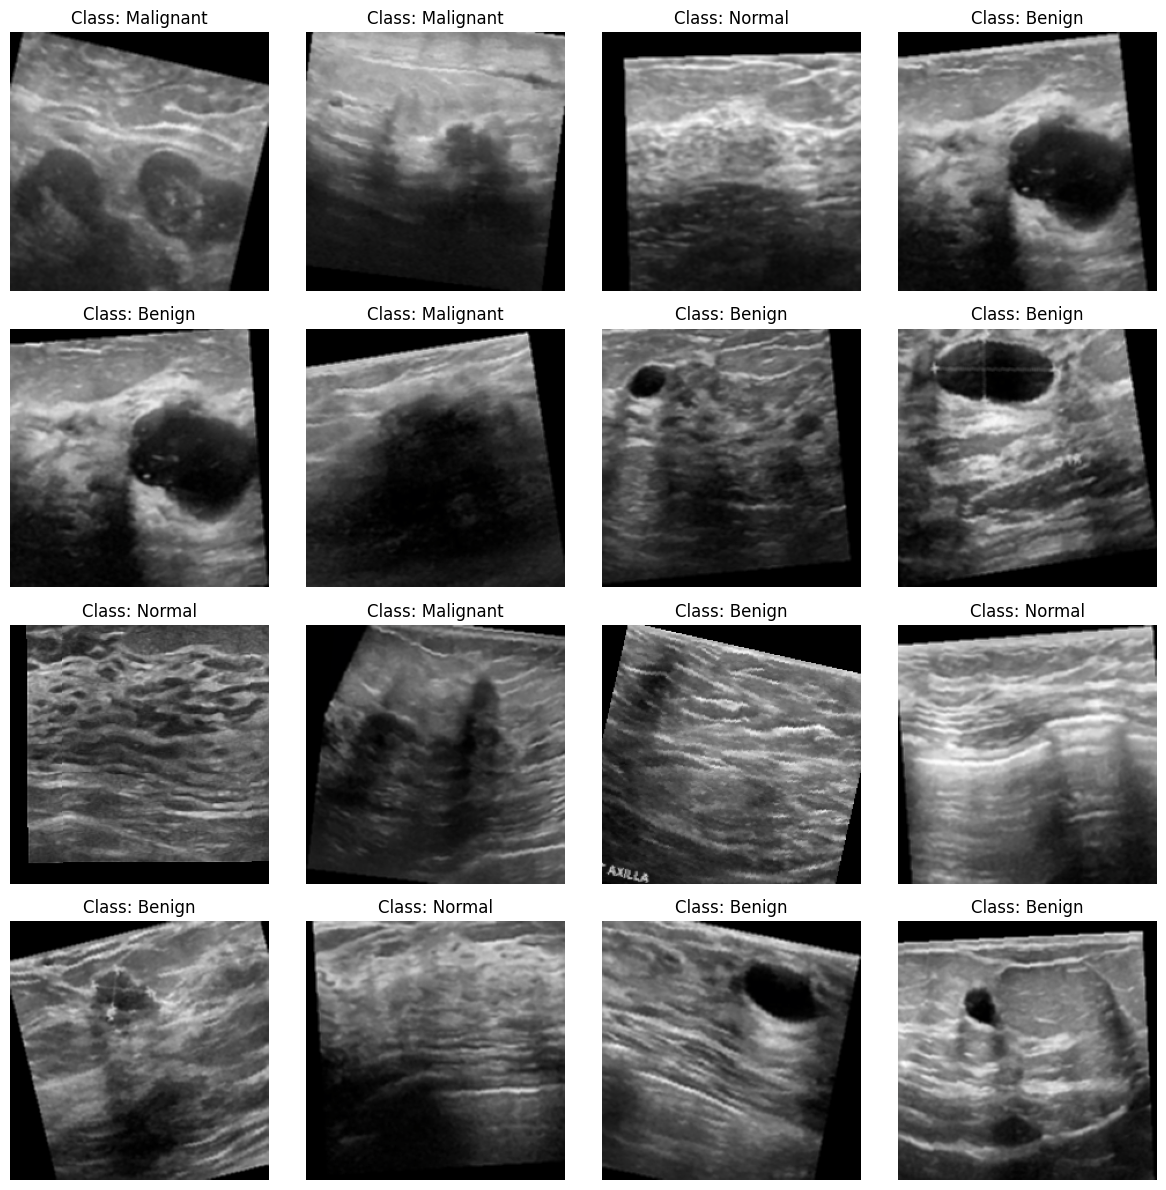

In [10]:
def show_batch(data_loader):
    # Get a batch of training data
    images, labels = next(iter(data_loader))
    batch_size = len(images)
    grid_size = min(4, batch_size)
    
    # Create a grid of images
    plt.figure(figsize=(12, 12))
    for i in range(grid_size * grid_size):
        if i >= batch_size:
            break
        # Convert tensor to numpy array and adjust dimensions
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(img)
        plt.title(f"Class: {CLASSES[labels[i]].capitalize()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a batch of training images
show_batch(train_loader)

In [11]:
## 5. Model Architecture

def create_model(num_classes):
    """Create a pre-trained ResNet model with a custom classification head"""
    # Load pre-trained ResNet-18
    model = models.resnet18(weights='DEFAULT')
    
    # Freeze most layers to speed up training and prevent overfitting
    for param in list(model.parameters())[:-20]:
        param.requires_grad = False
    
    # Modify the final fully connected layer for our classification task
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),  # Add dropout for regularization
        nn.Linear(num_features, num_classes)
    )
    
    return model

# Create the model and move it to the appropriate device
model = create_model(NUM_CLASSES)
model = model.to(device)

# Display model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
## 6. Training Functions

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    """Train the model and return the best model weights and training history"""
    best_val_acc = 0.0
    best_model_weights = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy for the epoch
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100 * train_correct / train_total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy for the epoch
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate
        if scheduler is not None:
            scheduler.step(val_loss)
        
        # Print epoch statistics
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")
    
    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    return model, history

In [13]:
def evaluate_model(model, test_loader):
    """Evaluate the model on the test set"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    report = classification_report(all_labels, all_preds, target_names=[c.capitalize() for c in CLASSES], digits=4)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print("\nClassification Report:")
    print(report)
    
    return all_preds, all_labels, all_probs, conf_matrix

In [14]:
# Run this in a code cell
#!pip install ipywidgets

## 7. Model Training

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Number of epochs - adjust based on your time constraints
# For a 2-hour project, you might want to reduce this
num_epochs = 200  # Try 5-10 for a quick project

# Train the model
print("Training model...")
trained_model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
)

# Save the model
model_path = os.path.join(OUTPUT_DIR, 'breast_ultrasound_classifier.pth')
torch.save(trained_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Training model...

Epoch 1/200


C:\Users\ksska\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.9152 | Train Acc: 65.28%
Val Loss: 0.8150 | Val Acc: 73.75%
New best model saved with validation accuracy: 73.75%

Epoch 2/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.6175 | Train Acc: 74.86%
Val Loss: 0.5852 | Val Acc: 77.50%
New best model saved with validation accuracy: 77.50%

Epoch 3/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.5282 | Train Acc: 77.94%
Val Loss: 0.4341 | Val Acc: 80.00%
New best model saved with validation accuracy: 80.00%

Epoch 4/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.4445 | Train Acc: 81.92%
Val Loss: 0.4487 | Val Acc: 78.75%

Epoch 5/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.3981 | Train Acc: 84.81%
Val Loss: 0.6641 | Val Acc: 75.00%

Epoch 6/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.3840 | Train Acc: 86.26%
Val Loss: 0.6349 | Val Acc: 73.75%

Epoch 7/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.3716 | Train Acc: 83.73%
Val Loss: 0.7757 | Val Acc: 76.25%

Epoch 8/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.2702 | Train Acc: 88.61%
Val Loss: 0.5005 | Val Acc: 78.75%

Epoch 9/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.2268 | Train Acc: 90.24%
Val Loss: 0.5786 | Val Acc: 82.50%
New best model saved with validation accuracy: 82.50%

Epoch 10/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.2273 | Train Acc: 92.77%
Val Loss: 0.6362 | Val Acc: 76.25%

Epoch 11/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1918 | Train Acc: 94.03%
Val Loss: 0.4516 | Val Acc: 86.25%
New best model saved with validation accuracy: 86.25%

Epoch 12/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1490 | Train Acc: 94.21%
Val Loss: 0.4784 | Val Acc: 86.25%

Epoch 13/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.2132 | Train Acc: 92.22%
Val Loss: 0.4698 | Val Acc: 83.75%

Epoch 14/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1498 | Train Acc: 94.58%
Val Loss: 0.5169 | Val Acc: 82.50%

Epoch 15/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1190 | Train Acc: 95.12%
Val Loss: 0.5300 | Val Acc: 85.00%

Epoch 16/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1119 | Train Acc: 96.56%
Val Loss: 0.5544 | Val Acc: 83.75%

Epoch 17/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1233 | Train Acc: 94.94%
Val Loss: 0.5347 | Val Acc: 83.75%

Epoch 18/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0917 | Train Acc: 97.29%
Val Loss: 0.6358 | Val Acc: 81.25%

Epoch 19/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1010 | Train Acc: 96.20%
Val Loss: 0.5881 | Val Acc: 80.00%

Epoch 20/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0885 | Train Acc: 97.29%
Val Loss: 0.6499 | Val Acc: 81.25%

Epoch 21/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0753 | Train Acc: 98.01%
Val Loss: 0.5893 | Val Acc: 82.50%

Epoch 22/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0888 | Train Acc: 96.93%
Val Loss: 0.5929 | Val Acc: 82.50%

Epoch 23/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0783 | Train Acc: 97.29%
Val Loss: 0.5999 | Val Acc: 78.75%

Epoch 24/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0480 | Train Acc: 98.55%
Val Loss: 0.5964 | Val Acc: 83.75%

Epoch 25/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0881 | Train Acc: 97.29%
Val Loss: 0.6257 | Val Acc: 80.00%

Epoch 26/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0660 | Train Acc: 98.01%
Val Loss: 0.6208 | Val Acc: 81.25%

Epoch 27/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0720 | Train Acc: 96.75%
Val Loss: 0.6730 | Val Acc: 78.75%

Epoch 28/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0440 | Train Acc: 98.92%
Val Loss: 0.6143 | Val Acc: 82.50%

Epoch 29/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0632 | Train Acc: 98.19%
Val Loss: 0.6176 | Val Acc: 80.00%

Epoch 30/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0765 | Train Acc: 96.93%
Val Loss: 0.6322 | Val Acc: 78.75%

Epoch 31/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0607 | Train Acc: 97.65%
Val Loss: 0.6921 | Val Acc: 78.75%

Epoch 32/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0918 | Train Acc: 96.93%
Val Loss: 0.7143 | Val Acc: 78.75%

Epoch 33/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0938 | Train Acc: 96.56%
Val Loss: 0.5549 | Val Acc: 80.00%

Epoch 34/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0671 | Train Acc: 97.83%
Val Loss: 0.6028 | Val Acc: 78.75%

Epoch 35/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0519 | Train Acc: 98.37%
Val Loss: 0.6325 | Val Acc: 80.00%

Epoch 36/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0584 | Train Acc: 98.55%
Val Loss: 0.6224 | Val Acc: 80.00%

Epoch 37/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0796 | Train Acc: 96.75%
Val Loss: 0.6732 | Val Acc: 80.00%

Epoch 38/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0638 | Train Acc: 97.47%
Val Loss: 0.5747 | Val Acc: 80.00%

Epoch 39/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0442 | Train Acc: 99.10%
Val Loss: 0.6083 | Val Acc: 81.25%

Epoch 40/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0642 | Train Acc: 97.47%
Val Loss: 0.5831 | Val Acc: 81.25%

Epoch 41/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0397 | Train Acc: 98.55%
Val Loss: 0.5639 | Val Acc: 82.50%

Epoch 42/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0728 | Train Acc: 98.01%
Val Loss: 0.7065 | Val Acc: 80.00%

Epoch 43/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0471 | Train Acc: 98.55%
Val Loss: 0.6200 | Val Acc: 81.25%

Epoch 44/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0511 | Train Acc: 98.19%
Val Loss: 0.6233 | Val Acc: 81.25%

Epoch 45/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0491 | Train Acc: 98.73%
Val Loss: 0.6541 | Val Acc: 80.00%

Epoch 46/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0699 | Train Acc: 97.47%
Val Loss: 0.7215 | Val Acc: 78.75%

Epoch 47/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0490 | Train Acc: 97.83%
Val Loss: 0.5870 | Val Acc: 80.00%

Epoch 48/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0758 | Train Acc: 96.75%
Val Loss: 0.6881 | Val Acc: 78.75%

Epoch 49/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0545 | Train Acc: 98.19%
Val Loss: 0.6330 | Val Acc: 80.00%

Epoch 50/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0694 | Train Acc: 97.47%
Val Loss: 0.6944 | Val Acc: 78.75%

Epoch 51/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0769 | Train Acc: 96.75%
Val Loss: 0.6150 | Val Acc: 81.25%

Epoch 52/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0542 | Train Acc: 98.19%
Val Loss: 0.6558 | Val Acc: 80.00%

Epoch 53/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0576 | Train Acc: 97.47%
Val Loss: 0.5528 | Val Acc: 82.50%

Epoch 54/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0717 | Train Acc: 97.11%
Val Loss: 0.6407 | Val Acc: 81.25%

Epoch 55/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0608 | Train Acc: 97.65%
Val Loss: 0.5903 | Val Acc: 81.25%

Epoch 56/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0573 | Train Acc: 97.65%
Val Loss: 0.6385 | Val Acc: 80.00%

Epoch 57/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0824 | Train Acc: 96.75%
Val Loss: 0.6571 | Val Acc: 78.75%

Epoch 58/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0605 | Train Acc: 97.65%
Val Loss: 0.5923 | Val Acc: 81.25%

Epoch 59/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0590 | Train Acc: 97.47%
Val Loss: 0.6048 | Val Acc: 80.00%

Epoch 60/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0650 | Train Acc: 97.83%
Val Loss: 0.5926 | Val Acc: 80.00%

Epoch 61/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0670 | Train Acc: 97.83%
Val Loss: 0.5795 | Val Acc: 81.25%

Epoch 62/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0874 | Train Acc: 97.11%
Val Loss: 0.6203 | Val Acc: 80.00%

Epoch 63/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0565 | Train Acc: 97.83%
Val Loss: 0.7881 | Val Acc: 78.75%

Epoch 64/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0727 | Train Acc: 97.11%
Val Loss: 0.6089 | Val Acc: 81.25%

Epoch 65/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0807 | Train Acc: 96.75%
Val Loss: 0.6527 | Val Acc: 80.00%

Epoch 66/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0751 | Train Acc: 96.93%
Val Loss: 0.5609 | Val Acc: 81.25%

Epoch 67/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0556 | Train Acc: 98.19%
Val Loss: 0.7048 | Val Acc: 80.00%

Epoch 68/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0643 | Train Acc: 97.29%
Val Loss: 0.6068 | Val Acc: 81.25%

Epoch 69/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0618 | Train Acc: 98.01%
Val Loss: 0.6277 | Val Acc: 80.00%

Epoch 70/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0561 | Train Acc: 98.37%
Val Loss: 0.6247 | Val Acc: 81.25%

Epoch 71/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0649 | Train Acc: 98.01%
Val Loss: 0.5711 | Val Acc: 82.50%

Epoch 72/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0788 | Train Acc: 97.29%
Val Loss: 0.6548 | Val Acc: 80.00%

Epoch 73/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0458 | Train Acc: 98.37%
Val Loss: 0.6545 | Val Acc: 80.00%

Epoch 74/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0553 | Train Acc: 98.55%
Val Loss: 0.6511 | Val Acc: 81.25%

Epoch 75/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0594 | Train Acc: 98.01%
Val Loss: 0.6186 | Val Acc: 80.00%

Epoch 76/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0634 | Train Acc: 97.83%
Val Loss: 0.5955 | Val Acc: 80.00%

Epoch 77/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0893 | Train Acc: 97.29%
Val Loss: 0.6024 | Val Acc: 81.25%

Epoch 78/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0664 | Train Acc: 97.83%
Val Loss: 0.5638 | Val Acc: 81.25%

Epoch 79/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0738 | Train Acc: 97.47%
Val Loss: 0.5905 | Val Acc: 80.00%

Epoch 80/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0645 | Train Acc: 98.01%
Val Loss: 0.6438 | Val Acc: 81.25%

Epoch 81/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0694 | Train Acc: 98.37%
Val Loss: 0.5821 | Val Acc: 81.25%

Epoch 82/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0581 | Train Acc: 98.19%
Val Loss: 0.6307 | Val Acc: 81.25%

Epoch 83/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0716 | Train Acc: 97.83%
Val Loss: 0.5686 | Val Acc: 80.00%

Epoch 84/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0645 | Train Acc: 98.19%
Val Loss: 0.6833 | Val Acc: 80.00%

Epoch 85/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0695 | Train Acc: 98.19%
Val Loss: 0.7079 | Val Acc: 80.00%

Epoch 86/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0519 | Train Acc: 98.73%
Val Loss: 0.5783 | Val Acc: 81.25%

Epoch 87/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0528 | Train Acc: 97.83%
Val Loss: 0.6551 | Val Acc: 80.00%

Epoch 88/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0642 | Train Acc: 98.19%
Val Loss: 0.7030 | Val Acc: 80.00%

Epoch 89/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0892 | Train Acc: 96.93%
Val Loss: 0.6379 | Val Acc: 80.00%

Epoch 90/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0712 | Train Acc: 97.29%
Val Loss: 0.5920 | Val Acc: 80.00%

Epoch 91/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0639 | Train Acc: 97.65%
Val Loss: 0.7241 | Val Acc: 80.00%

Epoch 92/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0479 | Train Acc: 98.92%
Val Loss: 0.5872 | Val Acc: 81.25%

Epoch 93/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0706 | Train Acc: 97.83%
Val Loss: 0.6098 | Val Acc: 80.00%

Epoch 94/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0716 | Train Acc: 97.47%
Val Loss: 0.5551 | Val Acc: 80.00%

Epoch 95/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0544 | Train Acc: 98.19%
Val Loss: 0.6268 | Val Acc: 81.25%

Epoch 96/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0832 | Train Acc: 96.02%
Val Loss: 0.6254 | Val Acc: 81.25%

Epoch 97/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0663 | Train Acc: 97.65%
Val Loss: 0.5916 | Val Acc: 81.25%

Epoch 98/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0622 | Train Acc: 97.83%
Val Loss: 0.6389 | Val Acc: 81.25%

Epoch 99/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0813 | Train Acc: 97.11%
Val Loss: 0.5499 | Val Acc: 83.75%

Epoch 100/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0786 | Train Acc: 96.56%
Val Loss: 0.7191 | Val Acc: 78.75%

Epoch 101/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0621 | Train Acc: 98.37%
Val Loss: 0.5984 | Val Acc: 80.00%

Epoch 102/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0741 | Train Acc: 97.11%
Val Loss: 0.6556 | Val Acc: 81.25%

Epoch 103/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0623 | Train Acc: 97.29%
Val Loss: 0.6105 | Val Acc: 81.25%

Epoch 104/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0524 | Train Acc: 98.37%
Val Loss: 0.7036 | Val Acc: 80.00%

Epoch 105/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0631 | Train Acc: 97.65%
Val Loss: 0.6729 | Val Acc: 80.00%

Epoch 106/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0616 | Train Acc: 97.65%
Val Loss: 0.6955 | Val Acc: 80.00%

Epoch 107/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0468 | Train Acc: 98.01%
Val Loss: 0.5822 | Val Acc: 80.00%

Epoch 108/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0606 | Train Acc: 97.65%
Val Loss: 0.5940 | Val Acc: 81.25%

Epoch 109/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0506 | Train Acc: 98.01%
Val Loss: 0.6697 | Val Acc: 80.00%

Epoch 110/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0432 | Train Acc: 99.10%
Val Loss: 0.6272 | Val Acc: 81.25%

Epoch 111/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0468 | Train Acc: 98.19%
Val Loss: 0.6424 | Val Acc: 80.00%

Epoch 112/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0622 | Train Acc: 97.29%
Val Loss: 0.6414 | Val Acc: 80.00%

Epoch 113/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0650 | Train Acc: 97.47%
Val Loss: 0.6428 | Val Acc: 81.25%

Epoch 114/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0700 | Train Acc: 97.47%
Val Loss: 0.6102 | Val Acc: 81.25%

Epoch 115/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0463 | Train Acc: 98.55%
Val Loss: 0.6542 | Val Acc: 81.25%

Epoch 116/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0646 | Train Acc: 98.37%
Val Loss: 0.6305 | Val Acc: 78.75%

Epoch 117/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0645 | Train Acc: 98.19%
Val Loss: 0.5833 | Val Acc: 80.00%

Epoch 118/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0581 | Train Acc: 98.01%
Val Loss: 0.5835 | Val Acc: 81.25%

Epoch 119/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0612 | Train Acc: 97.65%
Val Loss: 0.5550 | Val Acc: 81.25%

Epoch 120/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0564 | Train Acc: 98.55%
Val Loss: 0.6564 | Val Acc: 81.25%

Epoch 121/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0627 | Train Acc: 97.65%
Val Loss: 0.6252 | Val Acc: 81.25%

Epoch 122/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0850 | Train Acc: 97.47%
Val Loss: 0.7029 | Val Acc: 80.00%

Epoch 123/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0599 | Train Acc: 98.37%
Val Loss: 0.5687 | Val Acc: 81.25%

Epoch 124/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0643 | Train Acc: 98.37%
Val Loss: 0.5894 | Val Acc: 81.25%

Epoch 125/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0733 | Train Acc: 97.47%
Val Loss: 0.5794 | Val Acc: 81.25%

Epoch 126/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0513 | Train Acc: 98.55%
Val Loss: 0.6477 | Val Acc: 80.00%

Epoch 127/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0726 | Train Acc: 97.11%
Val Loss: 0.6197 | Val Acc: 78.75%

Epoch 128/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0801 | Train Acc: 97.65%
Val Loss: 0.6475 | Val Acc: 80.00%

Epoch 129/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0546 | Train Acc: 97.65%
Val Loss: 0.6203 | Val Acc: 80.00%

Epoch 130/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0591 | Train Acc: 98.73%
Val Loss: 0.7125 | Val Acc: 78.75%

Epoch 131/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0615 | Train Acc: 97.29%
Val Loss: 0.5605 | Val Acc: 80.00%

Epoch 132/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0911 | Train Acc: 96.20%
Val Loss: 0.5668 | Val Acc: 80.00%

Epoch 133/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0634 | Train Acc: 98.01%
Val Loss: 0.5746 | Val Acc: 78.75%

Epoch 134/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0632 | Train Acc: 98.73%
Val Loss: 0.6824 | Val Acc: 78.75%

Epoch 135/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0817 | Train Acc: 97.47%
Val Loss: 0.6950 | Val Acc: 80.00%

Epoch 136/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0714 | Train Acc: 96.93%
Val Loss: 0.6665 | Val Acc: 80.00%

Epoch 137/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0625 | Train Acc: 98.19%
Val Loss: 0.7116 | Val Acc: 78.75%

Epoch 138/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0516 | Train Acc: 98.55%
Val Loss: 0.6702 | Val Acc: 80.00%

Epoch 139/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0518 | Train Acc: 98.55%
Val Loss: 0.6337 | Val Acc: 80.00%

Epoch 140/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0598 | Train Acc: 98.01%
Val Loss: 0.6684 | Val Acc: 81.25%

Epoch 141/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0502 | Train Acc: 98.92%
Val Loss: 0.6180 | Val Acc: 81.25%

Epoch 142/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0612 | Train Acc: 97.65%
Val Loss: 0.6608 | Val Acc: 81.25%

Epoch 143/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0783 | Train Acc: 97.11%
Val Loss: 0.6554 | Val Acc: 80.00%

Epoch 144/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0652 | Train Acc: 98.37%
Val Loss: 0.6404 | Val Acc: 80.00%

Epoch 145/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0781 | Train Acc: 97.11%
Val Loss: 0.5911 | Val Acc: 80.00%

Epoch 146/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0492 | Train Acc: 98.37%
Val Loss: 0.6183 | Val Acc: 81.25%

Epoch 147/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0789 | Train Acc: 97.29%
Val Loss: 0.6819 | Val Acc: 80.00%

Epoch 148/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0592 | Train Acc: 97.47%
Val Loss: 0.6021 | Val Acc: 81.25%

Epoch 149/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0781 | Train Acc: 96.75%
Val Loss: 0.5820 | Val Acc: 81.25%

Epoch 150/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0618 | Train Acc: 98.01%
Val Loss: 0.6815 | Val Acc: 80.00%

Epoch 151/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0561 | Train Acc: 97.83%
Val Loss: 0.5597 | Val Acc: 80.00%

Epoch 152/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0659 | Train Acc: 97.83%
Val Loss: 0.5878 | Val Acc: 80.00%

Epoch 153/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0659 | Train Acc: 97.65%
Val Loss: 0.6811 | Val Acc: 80.00%

Epoch 154/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0701 | Train Acc: 97.29%
Val Loss: 0.5765 | Val Acc: 81.25%

Epoch 155/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0672 | Train Acc: 97.47%
Val Loss: 0.5932 | Val Acc: 81.25%

Epoch 156/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0561 | Train Acc: 98.19%
Val Loss: 0.5855 | Val Acc: 82.50%

Epoch 157/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0720 | Train Acc: 97.65%
Val Loss: 0.5750 | Val Acc: 82.50%

Epoch 158/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0522 | Train Acc: 97.65%
Val Loss: 0.6488 | Val Acc: 80.00%

Epoch 159/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0768 | Train Acc: 97.11%
Val Loss: 0.5666 | Val Acc: 82.50%

Epoch 160/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0407 | Train Acc: 99.10%
Val Loss: 0.6190 | Val Acc: 80.00%

Epoch 161/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0593 | Train Acc: 98.01%
Val Loss: 0.5892 | Val Acc: 82.50%

Epoch 162/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0556 | Train Acc: 97.83%
Val Loss: 0.6375 | Val Acc: 81.25%

Epoch 163/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0542 | Train Acc: 98.01%
Val Loss: 0.6283 | Val Acc: 80.00%

Epoch 164/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0637 | Train Acc: 98.19%
Val Loss: 0.6712 | Val Acc: 80.00%

Epoch 165/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0403 | Train Acc: 99.10%
Val Loss: 0.7071 | Val Acc: 80.00%

Epoch 166/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0706 | Train Acc: 97.47%
Val Loss: 0.5883 | Val Acc: 80.00%

Epoch 167/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0495 | Train Acc: 98.01%
Val Loss: 0.6199 | Val Acc: 81.25%

Epoch 168/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0596 | Train Acc: 97.47%
Val Loss: 0.6328 | Val Acc: 80.00%

Epoch 169/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0631 | Train Acc: 97.29%
Val Loss: 0.6438 | Val Acc: 80.00%

Epoch 170/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0669 | Train Acc: 98.37%
Val Loss: 0.6425 | Val Acc: 80.00%

Epoch 171/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0651 | Train Acc: 98.19%
Val Loss: 0.7042 | Val Acc: 78.75%

Epoch 172/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0785 | Train Acc: 96.20%
Val Loss: 0.5584 | Val Acc: 80.00%

Epoch 173/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0362 | Train Acc: 98.92%
Val Loss: 0.6064 | Val Acc: 81.25%

Epoch 174/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0651 | Train Acc: 97.29%
Val Loss: 0.7422 | Val Acc: 78.75%

Epoch 175/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0767 | Train Acc: 96.75%
Val Loss: 0.6642 | Val Acc: 81.25%

Epoch 176/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0534 | Train Acc: 98.19%
Val Loss: 0.6997 | Val Acc: 80.00%

Epoch 177/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0442 | Train Acc: 98.73%
Val Loss: 0.7257 | Val Acc: 80.00%

Epoch 178/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0541 | Train Acc: 97.83%
Val Loss: 0.6441 | Val Acc: 81.25%

Epoch 179/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0706 | Train Acc: 97.47%
Val Loss: 0.6129 | Val Acc: 80.00%

Epoch 180/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0529 | Train Acc: 97.83%
Val Loss: 0.6315 | Val Acc: 80.00%

Epoch 181/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0887 | Train Acc: 97.29%
Val Loss: 0.5686 | Val Acc: 81.25%

Epoch 182/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0564 | Train Acc: 98.01%
Val Loss: 0.5564 | Val Acc: 80.00%

Epoch 183/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0807 | Train Acc: 97.11%
Val Loss: 0.6610 | Val Acc: 80.00%

Epoch 184/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0759 | Train Acc: 98.55%
Val Loss: 0.6859 | Val Acc: 80.00%

Epoch 185/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0752 | Train Acc: 96.93%
Val Loss: 0.5432 | Val Acc: 82.50%

Epoch 186/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0638 | Train Acc: 97.47%
Val Loss: 0.6307 | Val Acc: 81.25%

Epoch 187/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0781 | Train Acc: 96.38%
Val Loss: 0.6352 | Val Acc: 80.00%

Epoch 188/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0736 | Train Acc: 97.65%
Val Loss: 0.6562 | Val Acc: 80.00%

Epoch 189/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0635 | Train Acc: 97.47%
Val Loss: 0.6850 | Val Acc: 80.00%

Epoch 190/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0855 | Train Acc: 96.93%
Val Loss: 0.6944 | Val Acc: 80.00%

Epoch 191/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0444 | Train Acc: 98.55%
Val Loss: 0.6714 | Val Acc: 78.75%

Epoch 192/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0677 | Train Acc: 96.93%
Val Loss: 0.6129 | Val Acc: 81.25%

Epoch 193/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0908 | Train Acc: 96.56%
Val Loss: 0.5851 | Val Acc: 80.00%

Epoch 194/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0457 | Train Acc: 98.73%
Val Loss: 0.6227 | Val Acc: 81.25%

Epoch 195/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0576 | Train Acc: 98.37%
Val Loss: 0.6054 | Val Acc: 80.00%

Epoch 196/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0523 | Train Acc: 97.47%
Val Loss: 0.6576 | Val Acc: 80.00%

Epoch 197/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0745 | Train Acc: 97.65%
Val Loss: 0.6394 | Val Acc: 81.25%

Epoch 198/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0701 | Train Acc: 97.29%
Val Loss: 0.5781 | Val Acc: 80.00%

Epoch 199/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0494 | Train Acc: 98.37%
Val Loss: 0.6106 | Val Acc: 81.25%

Epoch 200/200


Training:   0%|          | 0/35 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.0725 | Train Acc: 97.47%
Val Loss: 0.6561 | Val Acc: 80.00%
Model saved to C:\Users\ksska\OneDrive\Desktop\Project\results\breast_ultrasound_classifier.pth


In [15]:
## 8. Visualization and Evaluation

def plot_training_history(history):
    """Plot the training and validation loss and accuracy curves"""
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'))
    plt.show()

def plot_confusion_matrix(conf_matrix):
    """Plot the confusion matrix"""
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    classes = [c.capitalize() for c in CLASSES]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add values to the plot
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j],
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
    plt.show()

def plot_roc_curves(all_labels, all_probs):
    """Plot ROC curves for each class"""
    # Binarize the labels for one-vs-rest ROC
    from sklearn.preprocessing import label_binarize
    
    classes = np.unique(all_labels)
    y_bin = label_binarize(all_labels, classes=classes)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    all_probs = np.array(all_probs)
    
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_name.capitalize()} (AUC = {roc_auc[i]:.3f})')
    
    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curves.png'))
    plt.show()
    
    return roc_auc

In [16]:
def visualize_predictions(model, test_loader, num_images=8):
    """Visualize model predictions on test images"""
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(4, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {CLASSES[preds[j]].capitalize()}\nTrue: {CLASSES[labels[j]].capitalize()}',
                           color=("green" if preds[j] == labels[j] else "red"))
                
                # Denormalize and convert to displayable format
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_samples.png'))
                    return
    
    plt.tight_layout()
    plt.show()

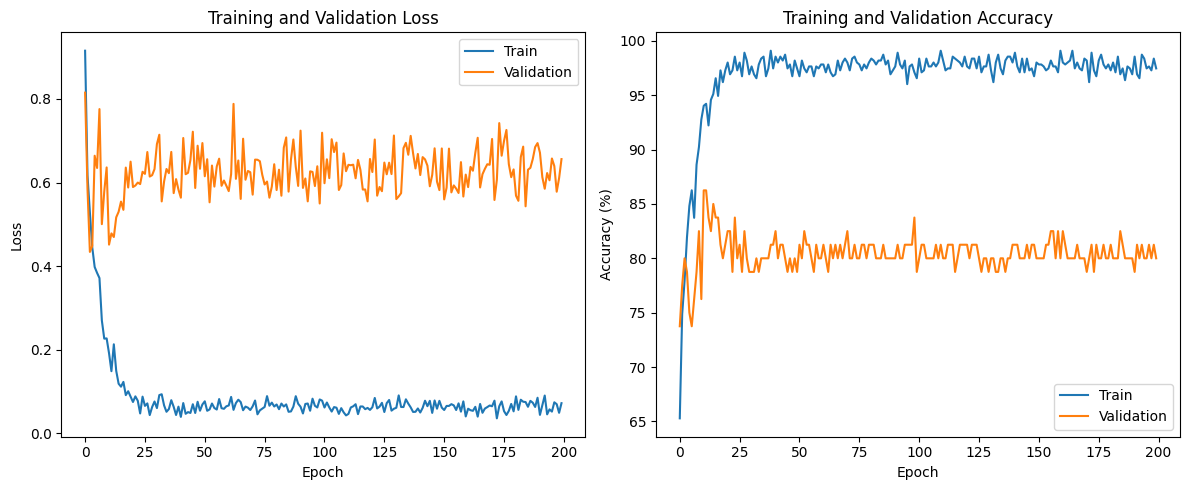

Evaluating model...


Testing:   0%|          | 0/10 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9000    0.6667    0.7660        27
      Benign     0.9146    0.8333    0.8721        90
   Malignant     0.6842    0.9286    0.7879        42

    accuracy                         0.8302       159
   macro avg     0.8329    0.8095    0.8086       159
weighted avg     0.8513    0.8302    0.8318       159



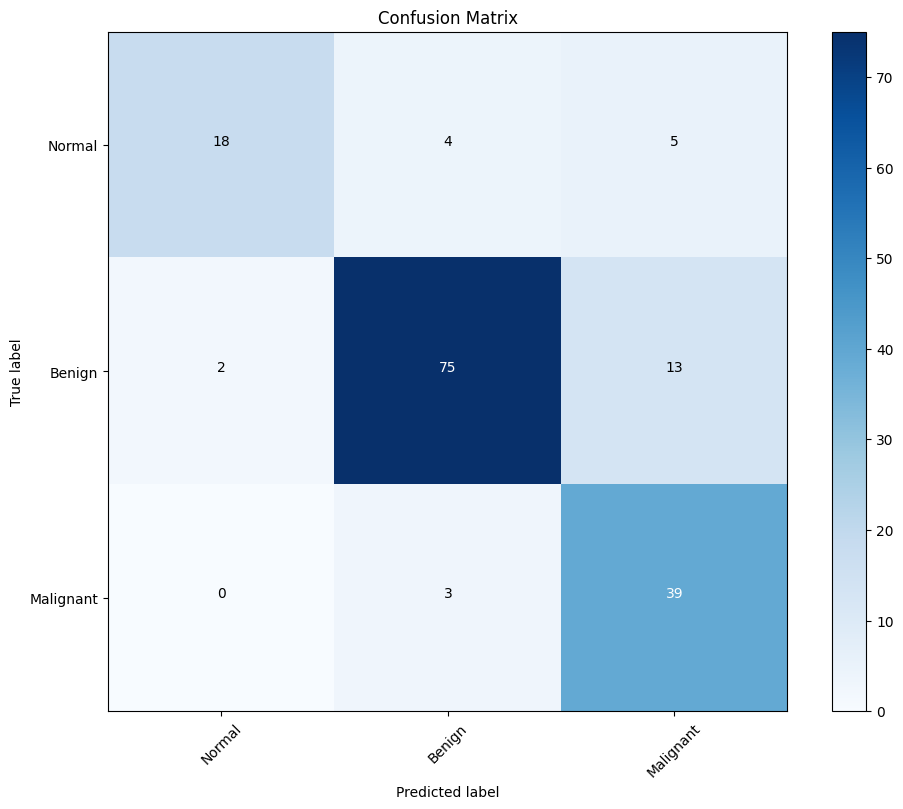

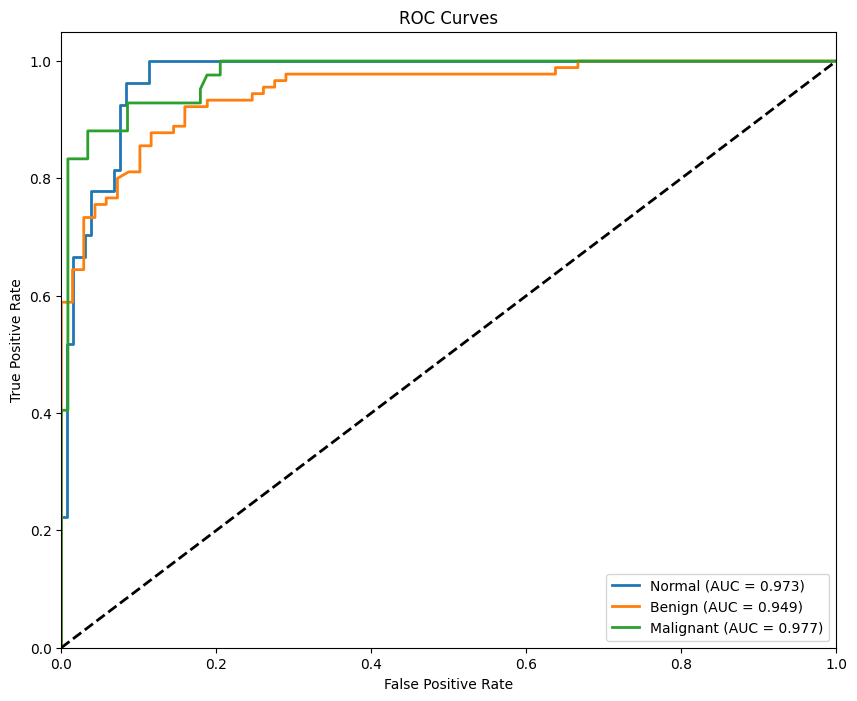

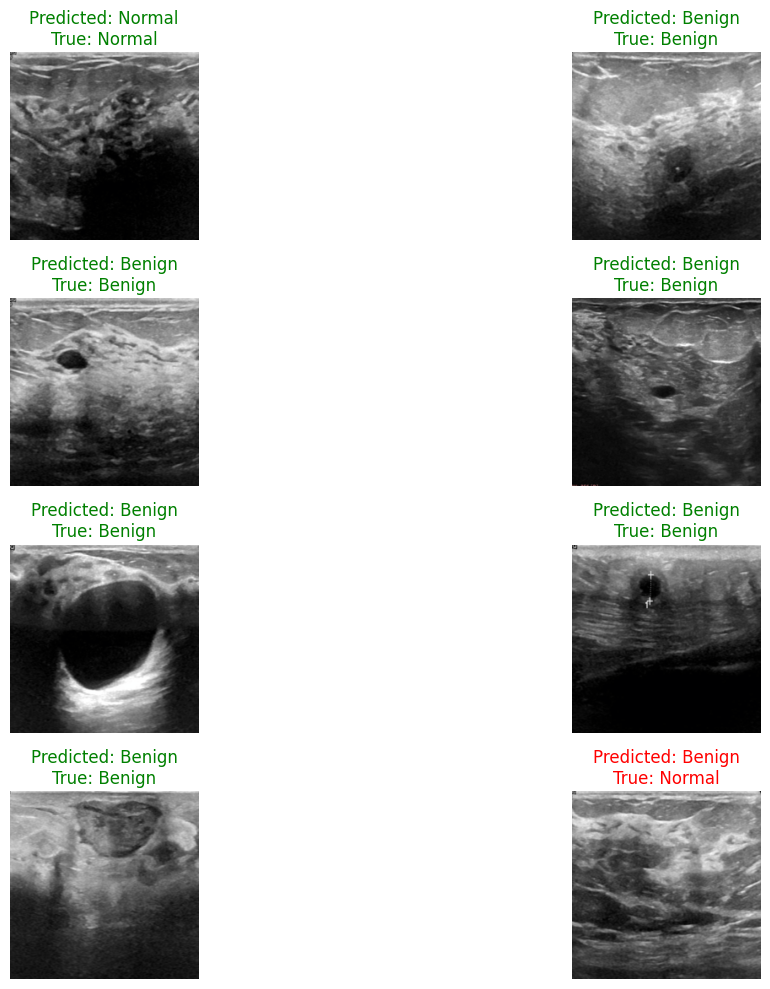

In [17]:
# Plot training history
plot_training_history(history)

# Evaluate model on test set
print("Evaluating model...")
preds, labels, probs, conf_matrix = evaluate_model(trained_model, test_loader)

# Plot confusion matrix
plot_confusion_matrix(conf_matrix)

# Plot ROC curves
roc_auc = plot_roc_curves(labels, probs)

# Visualize some predictions
visualize_predictions(trained_model, test_loader)